# YAASS Dataset

#### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those at familial high risk.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests

/Users/elyssabarrick/Work/Expts/Code


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'reshape2',
       'effsize', 'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='<U12')

In [3]:
#Function to assign names to disorders in FAME dataset
# def dx_name(data):
#     d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
#          5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
#     dx = d[data]
#     return dx 

# raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017_edit.xlsx')
# raw_sh['Gender'].replace(2, 'female', inplace=True)
# raw_sh['Gender'].replace(1,'male', inplace=True)

# raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
# raw_sz['Group'].replace(2, 'SZ', inplace=True)
# raw_sz['Group'].replace(1,'HC',inplace=True)
# raw_sz['Gender'].replace(1,'male',inplace=True)
# raw_sz['Gender'].replace(2,'female',inplace=True)

# raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_edit.xlsx')
# raw_fhr['Group'].replace(1, 'FHR', inplace=True)
# raw_fhr['Gender'].replace(2, 'female', inplace=True)
# raw_fhr['Gender'].replace(1,'male', inplace=True)

# g = raw_fhr.append(raw_sz)

# raw = g.append(raw_sh)
# pd.set_option('display.max_columns', 500)

In [4]:
# raw.to_csv('raw2.csv')

In [5]:
# #Function for creating a new column of z scores from existing column
# cols = raw[['IRI_EC','IRI_FS','IRI_PD','IRI_PT']]

# for col in cols:
#     col_zscore = col + '_z'
#     raw[col_zscore] = (raw[col] - raw[col].mean())/raw[col].std(ddof=0)

# raw.head()

In [36]:
raw = pd.read_excel(path2data + 'raw.xlsx')

In [37]:
raw.head()

,Group,ID,Gender,Age,Education,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,...,SIPS_General,SIPS_Negative,SIPS_Positive,SocAdjScale_SocialLeisure,SocAdjScale_Work,GFS_Role,GFS_Social,DSMDisorder,DSMDisorderType,DSMcomorbidities
0,FHR,2501,female,25,14.0,99.0,NaN,NaN,NaN,NaN,...,0.75,0.500000,1.4,NaN,NaN,NaN,NaN,1.0,7.0,2.0
1,FHR,2504,female,29,16.0,118.0,21.0,6.0,6.0,23.0,...,0.50,0.333333,1.0,1.2,1.5,NaN,NaN,1.0,7.0,2.0
2,FHR,2505,male,33,14.0,95.0,21.0,19.0,5.0,24.0,...,0.00,0.000000,0.4,1.9,1.5,NaN,NaN,0.0,0.0,0.0
3,FHR,2506,male,33,13.0,109.0,14.0,15.0,9.0,23.0,...,0.75,1.166667,1.2,1.8,1.4,NaN,NaN,1.0,4.0,1.0
4,FHR,2508,male,28,16.0,118.0,18.0,16.0,16.0,23.0,...,1.00,0.500000,1.4,1.3,1.7,NaN,NaN,0.0,NaN,0.0


### Demographics

In [8]:
raw.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     38
HR     27
SZ     26
Name: ID, dtype: int64

In [9]:
#Even split in HC group, more males in HR and SZ group - unsurprising...however mostly female in GHR group

raw.groupby('Group')['Gender'].value_counts()

Group  Gender
FHR    female    14
       male       5
HC     male      22
       female    16
HR     male      18
       female     9
SZ     male      16
       female    10
dtype: int64

Group       
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    38.000000
       mean     29.763158
       std      11.769025
       min      18.000000
       25%      21.000000
       50%      24.000000
       75%      41.500000
       max      55.000000
HR     count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
dtype: float64


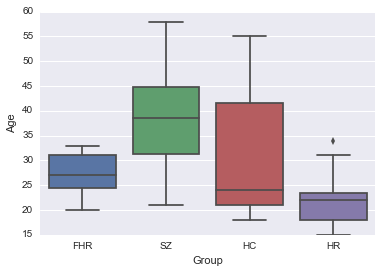

In [10]:
#Age
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [11]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group       
FHR    count     18.000000
       mean     117.000000
       std        9.779931
       min       95.000000
       25%      115.500000
       50%      118.000000
       75%      121.750000
       max      136.000000
HC     count     38.000000
       mean     112.105263
       std       11.668367
       min       88.000000
       25%      103.750000
       50%      114.000000
       75%      118.000000
       max      138.000000
HR     count     24.000000
       mean     106.791667
       std       17.688068
       min       79.000000
       25%       91.750000
       50%      106.500000
       75%      122.250000
       max      139.000000
SZ     count     26.000000
       mean     108.076923
       std       13.323432
       min       82.000000
       25%       99.000000
       50%      107.500000
       75%      118.750000
       max      133.000000
dtype: float64
Between group t-test on IQ HC and HR
t(60) = 1.43, p = 0.159
Between group t-test on IQ HC and SZ
t(62) = 1.

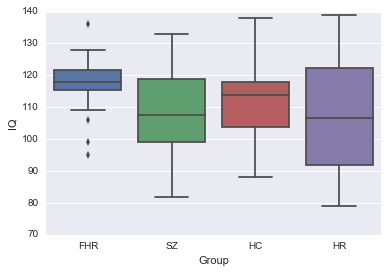

In [12]:
#IQ: Looks like FHR has significantly higher IQ than HC (and therefore all groups)

i = raw_IQ.groupby('Group')

print (i.IQ.describe())
print ('Between group t-test on IQ HC and HR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'HR']['IQ'])

print ('Between group t-test on IQ HC and SZ')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'SZ']['IQ'])

print ('Between group t-test on IQ HC and FHR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'FHR']['IQ'])

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Data Quality Check

In [49]:
#Dataframe where any row that has NAN value is dropped- will tell us how many participants have at least some missing 
#data
# sh_no_na = raw_sh.dropna()

In [50]:
# looks like most participants have some missing values...
# sh_no_na.groupby('Group')['ID'].nunique()

In [51]:
#Dataframe where any row that has less than 6 entries - which corresponds to anything other than demographic 
#information/subject ID entered - are dropped. These are participants that should not be included in the analyses.
# df_cleaned = raw.dropna(thresh=6)

In [52]:
#one participant that has no measures taken: 26195
# df_cleaned.groupby('Group')['ID'].nunique()

### Looking at Measures

                                Age        IQ  IRI_EC_z  IRI_FS_z  IRI_PD_z  \
Age                        1.000000 -0.177529  0.315909  0.062490 -0.275234   
IQ                        -0.177529  1.000000 -0.319619 -0.596151 -0.494619   
IRI_EC_z                   0.315909 -0.319619  1.000000  0.513932  0.149273   
IRI_FS_z                   0.062490 -0.596151  0.513932  1.000000  0.636242   
IRI_PD_z                  -0.275234 -0.494619  0.149273  0.636242  1.000000   
IRI_PT_z                   0.425971 -0.294858  0.907409  0.472417  0.024862   
SIPS_Disorganized         -0.373156 -0.609263 -0.102355  0.565995  0.725969   
SIPS_Negative             -0.288158 -0.680613 -0.162320  0.549218  0.716075   
SIPS_Positive             -0.154800 -0.683274  0.011525  0.681499  0.763933   
SIPS_General              -0.361578 -0.521739 -0.150635  0.519665  0.793956   
SocAdjScale_SocialLeisure  0.202699 -0.826144  0.347290  0.743744  0.722935   
GFS_Social                -0.346585  0.721777  0.075

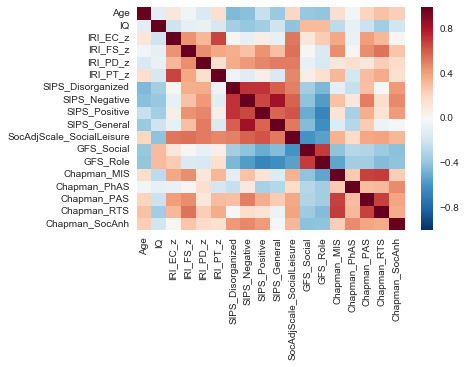

In [19]:
corr = raw[['Age','IQ','Group','Gender','IRI_EC_z','IRI_FS_z','IRI_PD_z','IRI_PT_z','SIPS_Disorganized','SIPS_Negative',
            'SIPS_Positive', 'SIPS_General','SocAdjScale_SocialLeisure','SocAdjScale_Work','GFS_Social','GFS_Role',
            'Chapman_MIS','Chapman_PhAS','Chapman_PAS','Chapman_RTS','Chapman_SocAnh']].corr()

print (corr.corr())

sns.heatmap(corr)

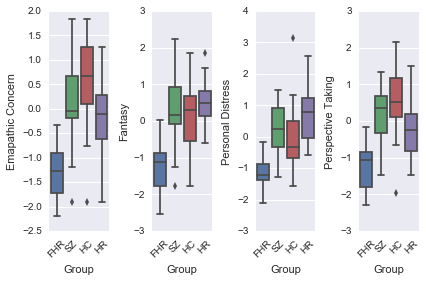

In [20]:
# Need to standardize the scoring
#FHR scored on a 5 point scale - HR, HC, and SZ on a 6 point scale

raw_iri = raw[np.isfinite(raw['IRI_EC_z'])]
raw_iri = raw[np.isfinite(raw['IRI_FS_z'])]
raw_iri = raw[np.isfinite(raw['IRI_PD_z'])]
raw_iri = raw[np.isfinite(raw['IRI_PT_z'])]

fig = plt.figure()
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_z', x='Group', data = raw_iri)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_z', x='Group', data = raw_iri)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_z', x='Group', data = raw_iri)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_z', x='Group', data = raw_iri)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

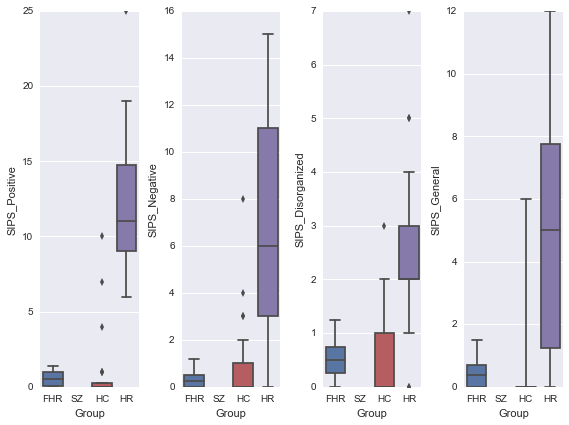

In [21]:
fig = plt.figure(figsize=(8, 6))
sips = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = raw)
sips = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = raw)
sips = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = raw)
sips = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = raw)
fig.tight_layout()

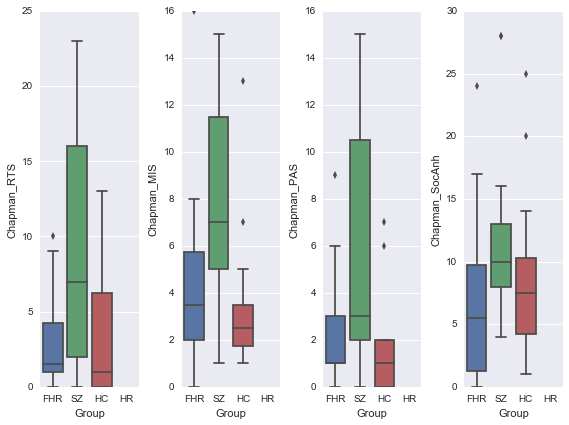

In [22]:
fig = plt.figure(figsize=(8, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

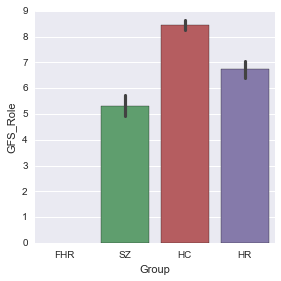

In [23]:
sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=raw)

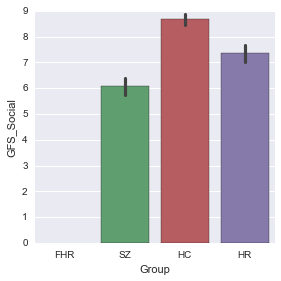

In [24]:
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=raw)

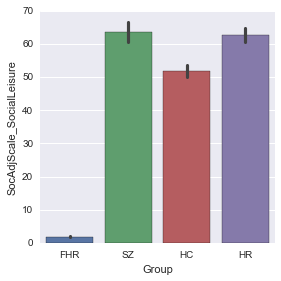

In [25]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

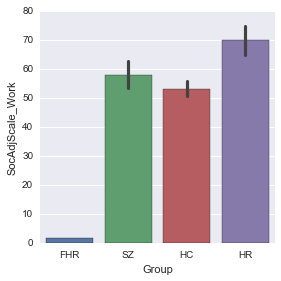

In [38]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)

### IRI and SAS

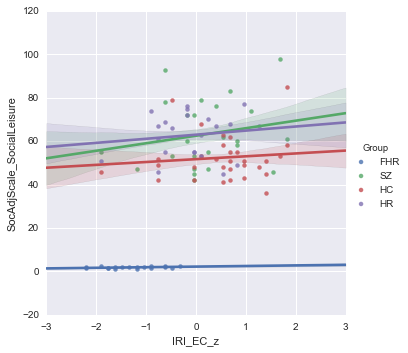

In [41]:

sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_EC_z',hue='Group',units='ID',ci=68,data=raw)b
# sns.plt.xlim(0.4,1.0)
# sns.plt.ylim(0.0,1.0)

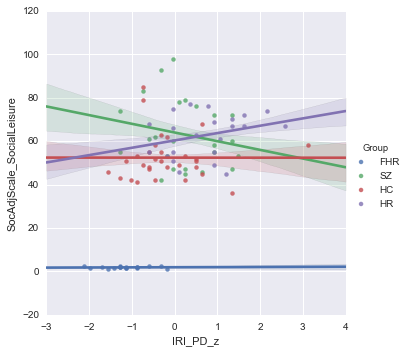

In [42]:
sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PD_z',hue='Group',units='ID',ci=68,data=raw)

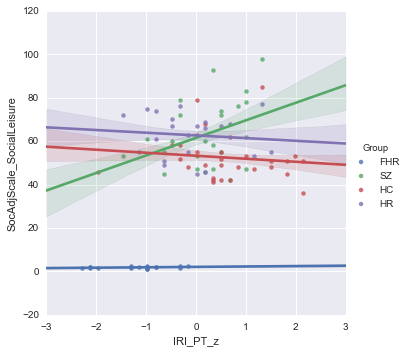

In [43]:
sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PT_z',hue='Group',units='ID',ci=68,data=raw)

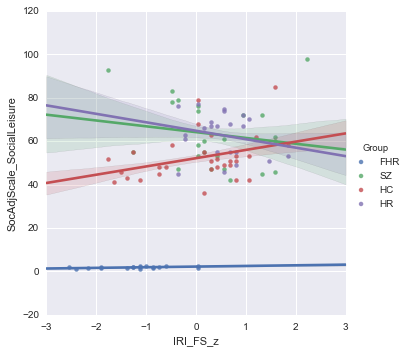

In [44]:
sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_FS_z',hue='Group',units='ID',ci=68,data=raw)

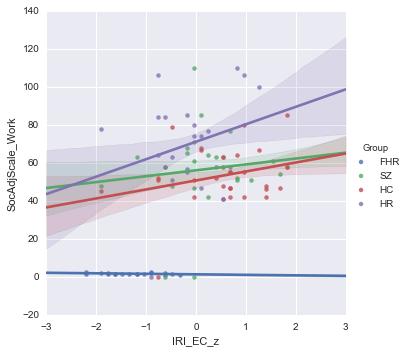

In [45]:
sns.lmplot(y='SocAdjScale_Work',x='IRI_EC_z',hue='Group',units='ID',ci=68,data=raw)

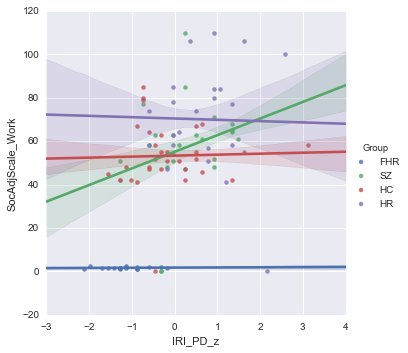

In [46]:
sns.lmplot(y='SocAdjScale_Work',x='IRI_PD_z',hue='Group',units='ID',ci=68,data=raw)

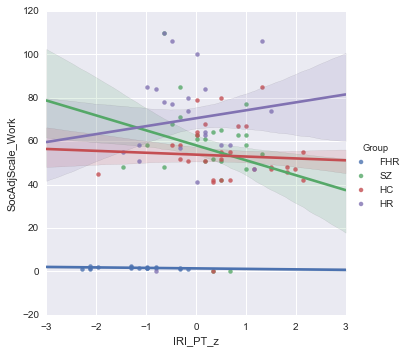

In [47]:
sns.lmplot(y='SocAdjScale_Work',x='IRI_PT_z',hue='Group',units='ID',ci=68,data=raw)

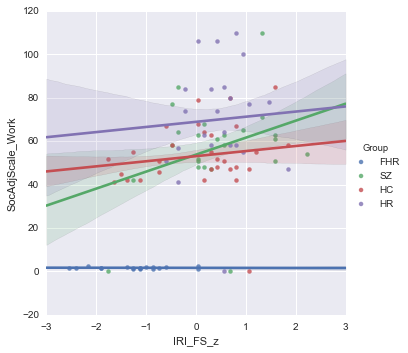

In [48]:
sns.lmplot(y='SocAdjScale_Work',x='IRI_FS_z',hue='Group',units='ID',ci=68,data=raw)

In [55]:
raw.SocAdjScale_SocialLeisure.dtype

dtype('float64')

In [57]:
raw_test = raw[~raw.Group == 'FHR']

TypeError: bad operand type for unary ~: 'str'